#  Modeling
Borrowing heavily from https://www.tensorflow.org/tutorials/images/classification to start

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

## Functions

In [2]:
def graphmodel(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Set-up before modeling

In [3]:
# Set variables for ease of manipulation

data_path = os.getcwd() + '\\PokeImages-by-type'
batch_size = 32
img_height = 128
img_width = 128

### Train / Test Split

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="training",
  seed=52,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_path,
  validation_split=0.3,
  subset="validation",
  seed=52,
  image_size=(img_height, img_width),
  batch_size=batch_size)

## Splitting the validation dataset into val and test

split = round(len(val_ds) / 1.5)
test_ds = val_ds.take(split)
val_ds = val_ds.skip(split)

Found 33877 files belonging to 17 classes.
Using 27102 files for training.
Found 33877 files belonging to 17 classes.
Using 10163 files for validation.


In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)

In [6]:
class_names

['Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water']

### Tune for performance
As recommended in the tutorial

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## First Simple Model
With batch size = 32

In [8]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [11]:
%%time

epochs=20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
847/847 [==============================] - 26s 13ms/step - loss: 2.2331 - accuracy: 0.3088 - val_loss: 1.7735 - val_accuracy: 0.4484
Epoch 2/20
847/847 [==============================] - 8s 9ms/step - loss: 1.2203 - accuracy: 0.6304 - val_loss: 1.0355 - val_accuracy: 0.7046
Epoch 3/20
847/847 [==============================] - 8s 9ms/step - loss: 0.5308 - accuracy: 0.8411 - val_loss: 0.7512 - val_accuracy: 0.8085
Epoch 4/20
847/847 [==============================] - 8s 9ms/step - loss: 0.2514 - accuracy: 0.9219 - val_loss: 0.7960 - val_accuracy: 0.8307
Epoch 5/20
847/847 [==============================] - 8s 9ms/step - loss: 0.1596 - accuracy: 0.9498 - val_loss: 0.7904 - val_accuracy: 0.8443
Epoch 6/20
847/847 [==============================] - 8s 9ms/step - loss: 0.1223 - accuracy: 0.9622 - val_loss: 0.9730 - val_accuracy: 0.8115
Epoch 7/20
847/847 [==============================] - 8s 9ms/step - loss: 0.1116 - accuracy: 0.9648 - val_loss: 0.9532 - val_accuracy: 0.8396
Epoc

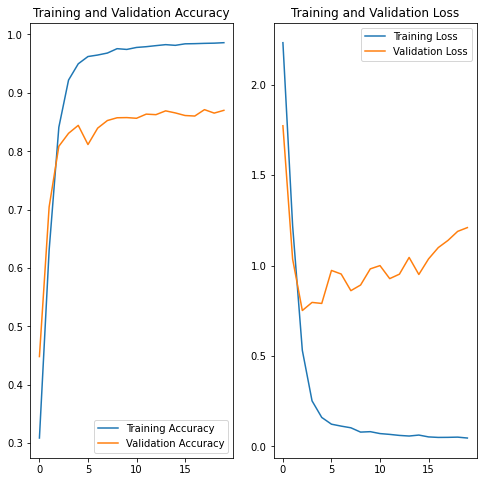

In [12]:
graphmodel(history)

#### First Model Evaluation
Accuracy of 87% for a model with 17 classes is a strong start.  There is clear evidence of overfitting and the loss in the validation data looks to be fairly high.

## Model 2: Adding Image Augmentation

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [14]:
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [15]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

In [16]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
%%time

epochs=50

history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
847/847 [==============================] - 32s 37ms/step - loss: 2.4559 - accuracy: 0.2382 - val_loss: 2.2983 - val_accuracy: 0.2737
Epoch 2/50
847/847 [==============================] - 30s 36ms/step - loss: 2.2239 - accuracy: 0.3009 - val_loss: 2.1583 - val_accuracy: 0.3193
Epoch 3/50
847/847 [==============================] - 31s 36ms/step - loss: 2.0666 - accuracy: 0.3451 - val_loss: 1.9894 - val_accuracy: 0.3785
Epoch 4/50
847/847 [==============================] - 30s 36ms/step - loss: 1.9163 - accuracy: 0.3882 - val_loss: 1.9307 - val_accuracy: 0.4004
Epoch 5/50
847/847 [==============================] - 30s 35ms/step - loss: 1.7875 - accuracy: 0.4297 - val_loss: 1.7729 - val_accuracy: 0.4552
Epoch 6/50
847/847 [==============================] - 30s 35ms/step - loss: 1.6643 - accuracy: 0.4696 - val_loss: 1.6803 - val_accuracy: 0.4765
Epoch 7/50
847/847 [==============================] - 30s 35ms/step - loss: 1.5593 - accuracy: 0.5024 - val_loss: 1.5621 - val_accuracy:

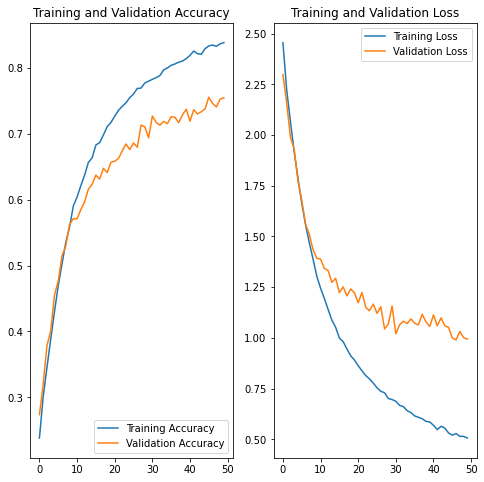

In [18]:
graphmodel(history2)

## Model 3: Batch Normalization, No Augmentation

In [19]:
model3 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),
  BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),
  BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),
  BatchNormalization(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [20]:
%%time

epochs=20

history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
847/847 [==============================] - 10s 11ms/step - loss: 2.6086 - accuracy: 0.2061 - val_loss: 2.5168 - val_accuracy: 0.2146
Epoch 2/20
847/847 [==============================] - 9s 11ms/step - loss: 2.1543 - accuracy: 0.3227 - val_loss: 2.0380 - val_accuracy: 0.3729
Epoch 3/20
847/847 [==============================] - 9s 11ms/step - loss: 1.5816 - accuracy: 0.5063 - val_loss: 1.5337 - val_accuracy: 0.5300
Epoch 4/20
847/847 [==============================] - 9s 11ms/step - loss: 1.0118 - accuracy: 0.6847 - val_loss: 1.2256 - val_accuracy: 0.6271
Epoch 5/20
847/847 [==============================] - 9s 11ms/step - loss: 0.6134 - accuracy: 0.8098 - val_loss: 0.9336 - val_accuracy: 0.7387
Epoch 6/20
847/847 [==============================] - 9s 11ms/step - loss: 0.3956 - accuracy: 0.8781 - val_loss: 0.8703 - val_accuracy: 0.7757
Epoch 7/20
847/847 [==============================] - 9s 11ms/step - loss: 0.2742 - accuracy: 0.9129 - val_loss: 0.7807 - val_accuracy: 0.803

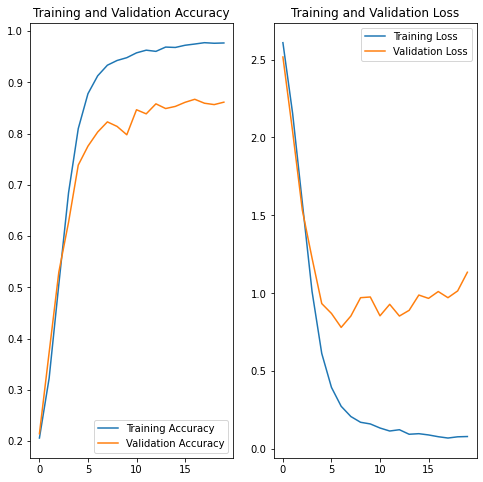

In [21]:
graphmodel(history3)

#### Model 3 Eval
Batch Normalization resulted in a roughly comparable, but slightly worse result than the FSM and a moderate performance penalty (~+3 seconds per epoch)

## Model 4: Mo' Dropout, Mo' Better?
Added several dropout layers and increased the number of epochs to allow more time to train 

In [22]:
model4 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes, activation='softmax')
])

model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [23]:
%%time

epochs=50

history4 = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
847/847 [==============================] - 8s 9ms/step - loss: 2.4918 - accuracy: 0.2351 - val_loss: 2.3192 - val_accuracy: 0.2690
Epoch 2/50
847/847 [==============================] - 7s 9ms/step - loss: 2.1421 - accuracy: 0.3353 - val_loss: 1.8341 - val_accuracy: 0.4350
Epoch 3/50
847/847 [==============================] - 7s 9ms/step - loss: 1.6927 - accuracy: 0.4662 - val_loss: 1.4362 - val_accuracy: 0.5682
Epoch 4/50
847/847 [==============================] - 7s 9ms/step - loss: 1.3019 - accuracy: 0.5878 - val_loss: 1.1467 - val_accuracy: 0.6780
Epoch 5/50
847/847 [==============================] - 7s 9ms/step - loss: 1.0391 - accuracy: 0.6676 - val_loss: 0.9374 - val_accuracy: 0.7449
Epoch 6/50
847/847 [==============================] - 7s 9ms/step - loss: 0.8532 - accuracy: 0.7259 - val_loss: 0.8407 - val_accuracy: 0.7718
Epoch 7/50
847/847 [==============================] - 7s 9ms/step - loss: 0.7393 - accuracy: 0.7548 - val_loss: 0.7693 - val_accuracy: 0.8020
Epoch 

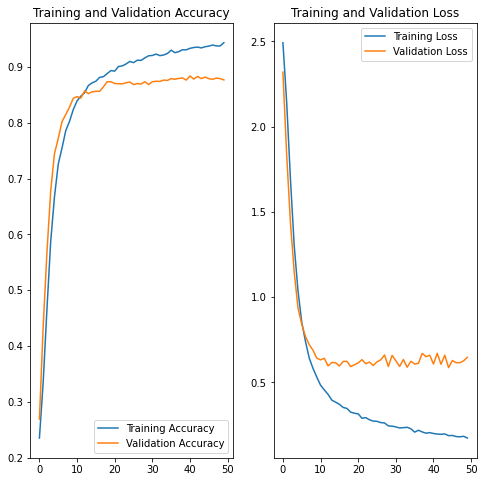

In [24]:
graphmodel(history4)

#### Model 4 Eval
Compared to the FSM, there was a moderate increase in validation accuracy (about .75%) and validation loss decreased by almost half. 

## Model 5: Longer Leash
Tweaked dropout higher, more epochs

In [25]:
model5 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes, activation='softmax')
])

model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [26]:
%%time

epochs=100

history5 = model5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
847/847 [==============================] - 8s 9ms/step - loss: 2.5051 - accuracy: 0.2223 - val_loss: 2.3085 - val_accuracy: 0.2803
Epoch 2/100
847/847 [==============================] - 7s 9ms/step - loss: 2.1335 - accuracy: 0.3312 - val_loss: 1.8684 - val_accuracy: 0.4128
Epoch 3/100
847/847 [==============================] - 7s 9ms/step - loss: 1.7674 - accuracy: 0.4397 - val_loss: 1.5058 - val_accuracy: 0.5546
Epoch 4/100
847/847 [==============================] - 7s 9ms/step - loss: 1.4491 - accuracy: 0.5421 - val_loss: 1.2582 - val_accuracy: 0.6265
Epoch 5/100
847/847 [==============================] - 7s 9ms/step - loss: 1.1970 - accuracy: 0.6128 - val_loss: 1.0953 - val_accuracy: 0.6946
Epoch 6/100
847/847 [==============================] - 7s 9ms/step - loss: 1.0141 - accuracy: 0.6744 - val_loss: 0.9823 - val_accuracy: 0.7233
Epoch 7/100
847/847 [==============================] - 7s 9ms/step - loss: 0.8885 - accuracy: 0.7136 - val_loss: 0.8668 - val_accuracy: 0.7635

Epoch 58/100
847/847 [==============================] - 7s 9ms/step - loss: 0.1783 - accuracy: 0.9411 - val_loss: 0.6536 - val_accuracy: 0.8760
Epoch 59/100
847/847 [==============================] - 7s 9ms/step - loss: 0.1797 - accuracy: 0.9413 - val_loss: 0.6055 - val_accuracy: 0.8793
Epoch 60/100
847/847 [==============================] - 7s 9ms/step - loss: 0.1748 - accuracy: 0.9425 - val_loss: 0.6540 - val_accuracy: 0.8787
Epoch 61/100
847/847 [==============================] - 7s 9ms/step - loss: 0.1854 - accuracy: 0.9395 - val_loss: 0.6173 - val_accuracy: 0.8858
Epoch 62/100
847/847 [==============================] - 7s 9ms/step - loss: 0.1701 - accuracy: 0.9423 - val_loss: 0.7149 - val_accuracy: 0.8766
Epoch 63/100
847/847 [==============================] - 7s 9ms/step - loss: 0.1764 - accuracy: 0.9426 - val_loss: 0.6362 - val_accuracy: 0.8772
Epoch 64/100
847/847 [==============================] - 7s 9ms/step - loss: 0.1693 - accuracy: 0.9457 - val_loss: 0.6772 - val_accuracy:

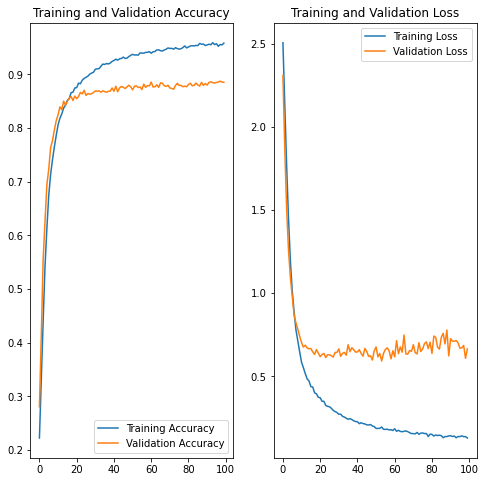

In [27]:
graphmodel(history5)

#### Model 5 Eval
Roughly a 1% increase in validation accuracy over model 4 with some increase in loss.  Clearly stalled in the 50-60 range.

## Model 6 Another Dropout Layer?

In [28]:
model6 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

model6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [29]:
%%time

epochs=100

history6 = model6.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
847/847 [==============================] - 8s 9ms/step - loss: 2.5560 - accuracy: 0.2121 - val_loss: 2.4177 - val_accuracy: 0.2486
Epoch 2/100
847/847 [==============================] - 7s 9ms/step - loss: 2.3378 - accuracy: 0.2791 - val_loss: 2.1853 - val_accuracy: 0.3131
Epoch 3/100
847/847 [==============================] - 7s 9ms/step - loss: 2.0991 - accuracy: 0.3397 - val_loss: 1.9205 - val_accuracy: 0.4051
Epoch 4/100
847/847 [==============================] - 7s 9ms/step - loss: 1.8644 - accuracy: 0.4040 - val_loss: 1.6535 - val_accuracy: 0.5286
Epoch 5/100
847/847 [==============================] - 7s 9ms/step - loss: 1.6538 - accuracy: 0.4697 - val_loss: 1.3977 - val_accuracy: 0.6170
Epoch 6/100
847/847 [==============================] - 7s 9ms/step - loss: 1.4689 - accuracy: 0.5263 - val_loss: 1.2820 - val_accuracy: 0.6647
Epoch 7/100
847/847 [==============================] - 7s 9ms/step - loss: 1.3283 - accuracy: 0.5709 - val_loss: 1.0923 - val_accuracy: 0.6896

Epoch 58/100
847/847 [==============================] - 7s 9ms/step - loss: 0.3670 - accuracy: 0.8762 - val_loss: 0.4641 - val_accuracy: 0.8935
Epoch 59/100
847/847 [==============================] - 7s 9ms/step - loss: 0.3645 - accuracy: 0.8781 - val_loss: 0.4699 - val_accuracy: 0.8902
Epoch 60/100
847/847 [==============================] - 8s 9ms/step - loss: 0.3603 - accuracy: 0.8782 - val_loss: 0.4514 - val_accuracy: 0.8890
Epoch 61/100
847/847 [==============================] - 7s 9ms/step - loss: 0.3554 - accuracy: 0.8826 - val_loss: 0.4518 - val_accuracy: 0.8935
Epoch 62/100
847/847 [==============================] - 7s 9ms/step - loss: 0.3511 - accuracy: 0.8810 - val_loss: 0.4464 - val_accuracy: 0.8914
Epoch 63/100
847/847 [==============================] - 7s 9ms/step - loss: 0.3522 - accuracy: 0.8834 - val_loss: 0.4598 - val_accuracy: 0.8875
Epoch 64/100
847/847 [==============================] - 7s 9ms/step - loss: 0.3582 - accuracy: 0.8807 - val_loss: 0.4375 - val_accuracy:

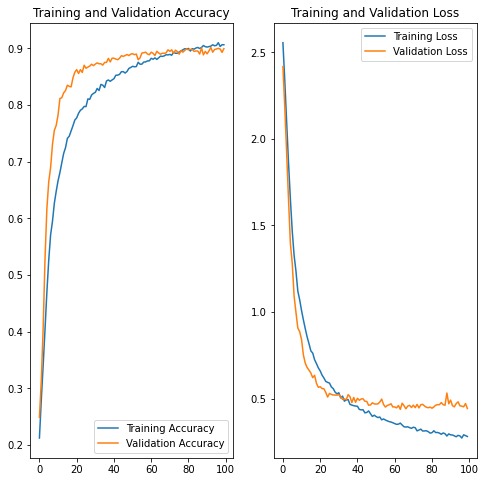

In [30]:
graphmodel(history6)

#### Model 6 Eval
Almost a 2% increase in accuracy compared to the first simple model and the lowest validation loss yet.

## Model 7: Regularization
Added a dense layer and reduced dropout, to counterbalance regularization

In [31]:
model7 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu', kernel_regularizer='l2'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.25),
  layers.Dense(num_classes, activation='softmax')
])

model7.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [32]:
%%time

epochs=50

history7 = model7.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
847/847 [==============================] - 8s 9ms/step - loss: 2.6723 - accuracy: 0.2074 - val_loss: 2.5443 - val_accuracy: 0.2356
Epoch 2/50
847/847 [==============================] - 8s 9ms/step - loss: 2.5157 - accuracy: 0.2584 - val_loss: 2.4769 - val_accuracy: 0.2687
Epoch 3/50
847/847 [==============================] - 8s 9ms/step - loss: 2.4814 - accuracy: 0.2769 - val_loss: 2.4409 - val_accuracy: 0.2817
Epoch 4/50
847/847 [==============================] - 8s 9ms/step - loss: 2.4254 - accuracy: 0.3105 - val_loss: 2.4474 - val_accuracy: 0.3013
Epoch 5/50
847/847 [==============================] - 8s 9ms/step - loss: 2.3727 - accuracy: 0.3613 - val_loss: 2.3088 - val_accuracy: 0.3886
Epoch 6/50
847/847 [==============================] - 8s 9ms/step - loss: 2.2776 - accuracy: 0.4421 - val_loss: 2.2683 - val_accuracy: 0.4558
Epoch 7/50
847/847 [==============================] - 7s 9ms/step - loss: 2.1542 - accuracy: 0.5168 - val_loss: 2.2300 - val_accuracy: 0.5067
Epoch 

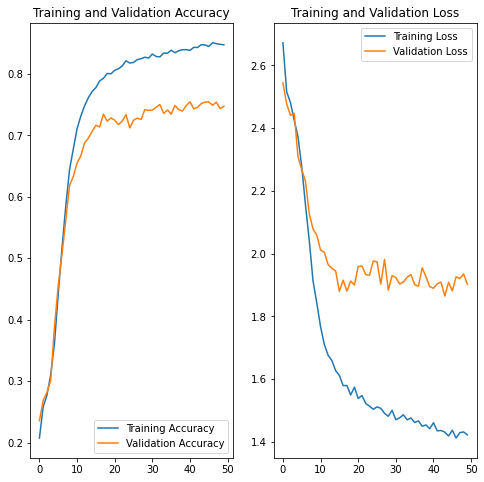

In [33]:
graphmodel(history7)

#### Model 7 Eval
Back to the drawing board.

## Model 8: Added convultional layer
Slightly tweaked more drop out layers from Model 5

In [34]:
model8 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes, activation='softmax')
])

model8.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [35]:
%%time

epochs=100

history8 = model8.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
847/847 [==============================] - 9s 10ms/step - loss: 2.5659 - accuracy: 0.1966 - val_loss: 2.4557 - val_accuracy: 0.2314
Epoch 2/100
847/847 [==============================] - 8s 9ms/step - loss: 2.3576 - accuracy: 0.2660 - val_loss: 2.2035 - val_accuracy: 0.3247
Epoch 3/100
847/847 [==============================] - 8s 9ms/step - loss: 2.1006 - accuracy: 0.3436 - val_loss: 1.9350 - val_accuracy: 0.4108
Epoch 4/100
847/847 [==============================] - 8s 9ms/step - loss: 1.8666 - accuracy: 0.4122 - val_loss: 1.7183 - val_accuracy: 0.4777
Epoch 5/100
847/847 [==============================] - 8s 9ms/step - loss: 1.6743 - accuracy: 0.4687 - val_loss: 1.5583 - val_accuracy: 0.5268
Epoch 6/100
847/847 [==============================] - 8s 9ms/step - loss: 1.5173 - accuracy: 0.5139 - val_loss: 1.3497 - val_accuracy: 0.6037
Epoch 7/100
847/847 [==============================] - 8s 9ms/step - loss: 1.3832 - accuracy: 0.5554 - val_loss: 1.2856 - val_accuracy: 0.619

Epoch 58/100
847/847 [==============================] - 8s 9ms/step - loss: 0.4545 - accuracy: 0.8504 - val_loss: 0.5765 - val_accuracy: 0.8503
Epoch 59/100
847/847 [==============================] - 8s 9ms/step - loss: 0.4514 - accuracy: 0.8519 - val_loss: 0.5816 - val_accuracy: 0.8479
Epoch 60/100
847/847 [==============================] - 8s 9ms/step - loss: 0.4476 - accuracy: 0.8530 - val_loss: 0.6007 - val_accuracy: 0.8488
Epoch 61/100
847/847 [==============================] - 8s 9ms/step - loss: 0.4543 - accuracy: 0.8503 - val_loss: 0.5902 - val_accuracy: 0.8503
Epoch 62/100
847/847 [==============================] - 8s 9ms/step - loss: 0.4475 - accuracy: 0.8516 - val_loss: 0.6011 - val_accuracy: 0.8464
Epoch 63/100
847/847 [==============================] - 8s 9ms/step - loss: 0.4398 - accuracy: 0.8558 - val_loss: 0.5714 - val_accuracy: 0.8547
Epoch 64/100
847/847 [==============================] - 8s 9ms/step - loss: 0.4331 - accuracy: 0.8566 - val_loss: 0.5798 - val_accuracy:

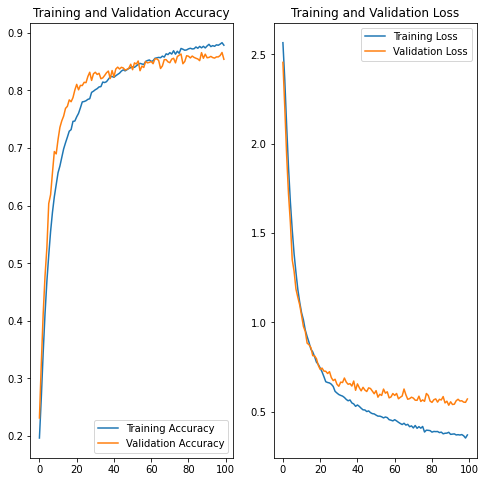

In [36]:
graphmodel(history8)

## Model 9
Changed kernal size for biggest conv layer

In [37]:
model9 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes, activation='softmax')
])

model9.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [38]:
%%time

epochs=100

history9 = model9.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
847/847 [==============================] - 9s 10ms/step - loss: 2.5703 - accuracy: 0.1976 - val_loss: 2.4726 - val_accuracy: 0.2391
Epoch 2/100
847/847 [==============================] - 8s 10ms/step - loss: 2.3542 - accuracy: 0.2659 - val_loss: 2.2564 - val_accuracy: 0.3063
Epoch 3/100
847/847 [==============================] - 8s 10ms/step - loss: 2.1030 - accuracy: 0.3375 - val_loss: 1.9721 - val_accuracy: 0.3871
Epoch 4/100
847/847 [==============================] - 8s 10ms/step - loss: 1.8646 - accuracy: 0.4105 - val_loss: 1.7022 - val_accuracy: 0.4895
Epoch 5/100
847/847 [==============================] - 8s 10ms/step - loss: 1.6415 - accuracy: 0.4763 - val_loss: 1.4764 - val_accuracy: 0.5590
Epoch 6/100
847/847 [==============================] - 8s 10ms/step - loss: 1.4550 - accuracy: 0.5331 - val_loss: 1.3360 - val_accuracy: 0.5999
Epoch 7/100
847/847 [==============================] - 8s 10ms/step - loss: 1.3077 - accuracy: 0.5815 - val_loss: 1.2407 - val_accuracy:

847/847 [==============================] - 8s 10ms/step - loss: 0.3053 - accuracy: 0.9002 - val_loss: 0.5640 - val_accuracy: 0.8574
Epoch 58/100
847/847 [==============================] - 8s 10ms/step - loss: 0.2994 - accuracy: 0.9026 - val_loss: 0.5590 - val_accuracy: 0.8668
Epoch 59/100
847/847 [==============================] - 8s 10ms/step - loss: 0.3066 - accuracy: 0.8996 - val_loss: 0.6150 - val_accuracy: 0.8503
Epoch 60/100
847/847 [==============================] - 8s 10ms/step - loss: 0.2970 - accuracy: 0.9049 - val_loss: 0.5657 - val_accuracy: 0.8656
Epoch 61/100
847/847 [==============================] - 8s 10ms/step - loss: 0.2951 - accuracy: 0.9031 - val_loss: 0.6019 - val_accuracy: 0.8612
Epoch 62/100
847/847 [==============================] - 8s 10ms/step - loss: 0.2933 - accuracy: 0.9032 - val_loss: 0.5954 - val_accuracy: 0.8579
Epoch 63/100
847/847 [==============================] - 8s 10ms/step - loss: 0.2838 - accuracy: 0.9065 - val_loss: 0.5914 - val_accuracy: 0.857

## Model 10 Long Augument

In [39]:
model10 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes, activation='softmax')
])

model10.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [40]:
%%time

epochs=200

history10 = model10.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/200
847/847 [==============================] - 33s 38ms/step - loss: 2.6063 - accuracy: 0.1846 - val_loss: 2.5329 - val_accuracy: 0.2175
Epoch 2/200
847/847 [==============================] - 32s 38ms/step - loss: 2.4881 - accuracy: 0.2241 - val_loss: 2.4630 - val_accuracy: 0.2447
Epoch 3/200
847/847 [==============================] - 31s 37ms/step - loss: 2.4120 - accuracy: 0.2490 - val_loss: 2.3399 - val_accuracy: 0.2675
Epoch 4/200
847/847 [==============================] - 31s 36ms/step - loss: 2.3429 - accuracy: 0.2677 - val_loss: 2.2544 - val_accuracy: 0.2989
Epoch 5/200
847/847 [==============================] - 31s 36ms/step - loss: 2.2718 - accuracy: 0.2866 - val_loss: 2.1846 - val_accuracy: 0.3099
Epoch 6/200
847/847 [==============================] - 31s 36ms/step - loss: 2.2089 - accuracy: 0.3025 - val_loss: 2.1227 - val_accuracy: 0.3365
Epoch 7/200
847/847 [==============================] - 31s 36ms/step - loss: 2.1569 - accuracy: 0.3199 - val_loss: 2.0485 - val_ac

847/847 [==============================] - 31s 36ms/step - loss: 1.3671 - accuracy: 0.5539 - val_loss: 1.2350 - val_accuracy: 0.6233
Epoch 58/200
847/847 [==============================] - 31s 36ms/step - loss: 1.3521 - accuracy: 0.5617 - val_loss: 1.2724 - val_accuracy: 0.6058
Epoch 59/200
847/847 [==============================] - 31s 36ms/step - loss: 1.3621 - accuracy: 0.5575 - val_loss: 1.2589 - val_accuracy: 0.6150
Epoch 60/200
847/847 [==============================] - 31s 36ms/step - loss: 1.3452 - accuracy: 0.5635 - val_loss: 1.2603 - val_accuracy: 0.6209
Epoch 61/200
847/847 [==============================] - 30s 36ms/step - loss: 1.3466 - accuracy: 0.5612 - val_loss: 1.2624 - val_accuracy: 0.6168
Epoch 62/200
847/847 [==============================] - 31s 36ms/step - loss: 1.3405 - accuracy: 0.5673 - val_loss: 1.2799 - val_accuracy: 0.6067
Epoch 63/200
847/847 [==============================] - 30s 36ms/step - loss: 1.3247 - accuracy: 0.5692 - val_loss: 1.2325 - val_accuracy

847/847 [==============================] - 30s 36ms/step - loss: 1.1913 - accuracy: 0.6093 - val_loss: 1.1603 - val_accuracy: 0.6508
Epoch 114/200
847/847 [==============================] - 29s 35ms/step - loss: 1.1790 - accuracy: 0.6157 - val_loss: 1.1008 - val_accuracy: 0.6748
Epoch 115/200
847/847 [==============================] - 30s 35ms/step - loss: 1.1864 - accuracy: 0.6089 - val_loss: 1.1298 - val_accuracy: 0.6534
Epoch 116/200
847/847 [==============================] - 30s 36ms/step - loss: 1.1817 - accuracy: 0.6145 - val_loss: 1.0708 - val_accuracy: 0.6792
Epoch 117/200
847/847 [==============================] - 31s 37ms/step - loss: 1.1733 - accuracy: 0.6158 - val_loss: 1.1352 - val_accuracy: 0.6526
Epoch 118/200
847/847 [==============================] - 32s 37ms/step - loss: 1.1580 - accuracy: 0.6194 - val_loss: 1.1017 - val_accuracy: 0.6656
Epoch 119/200
847/847 [==============================] - 31s 37ms/step - loss: 1.1718 - accuracy: 0.6182 - val_loss: 1.1093 - val_ac

Epoch 169/200
847/847 [==============================] - 31s 37ms/step - loss: 1.1016 - accuracy: 0.6430 - val_loss: 1.0487 - val_accuracy: 0.6869
Epoch 170/200
847/847 [==============================] - 31s 37ms/step - loss: 1.1096 - accuracy: 0.6370 - val_loss: 1.0354 - val_accuracy: 0.6970
Epoch 171/200
847/847 [==============================] - 32s 38ms/step - loss: 1.1099 - accuracy: 0.6412 - val_loss: 1.0286 - val_accuracy: 0.6964
Epoch 172/200
847/847 [==============================] - 32s 38ms/step - loss: 1.1103 - accuracy: 0.6384 - val_loss: 1.0327 - val_accuracy: 0.6848
Epoch 173/200
847/847 [==============================] - 31s 37ms/step - loss: 1.0955 - accuracy: 0.6412 - val_loss: 1.0754 - val_accuracy: 0.6745
Epoch 174/200
847/847 [==============================] - 32s 37ms/step - loss: 1.1011 - accuracy: 0.6453 - val_loss: 1.0621 - val_accuracy: 0.6890
Epoch 175/200
847/847 [==============================] - 31s 37ms/step - loss: 1.0897 - accuracy: 0.6427 - val_loss: 1

## Model 11: Augment, no drop
Additional dense layer

In [41]:
model11 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(256, activation='relu'),  
  layers.Dense(num_classes, activation='softmax')
])

model11.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [42]:
%%time

epochs=50

history11 = model11.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
847/847 [==============================] - 32s 37ms/step - loss: 2.5151 - accuracy: 0.2185 - val_loss: 2.3927 - val_accuracy: 0.2563
Epoch 2/50
847/847 [==============================] - 31s 37ms/step - loss: 2.2831 - accuracy: 0.2889 - val_loss: 2.1817 - val_accuracy: 0.3057
Epoch 3/50
847/847 [==============================] - 31s 36ms/step - loss: 2.0696 - accuracy: 0.3414 - val_loss: 1.9656 - val_accuracy: 0.3747
Epoch 4/50
847/847 [==============================] - 32s 37ms/step - loss: 1.8754 - accuracy: 0.4088 - val_loss: 1.8959 - val_accuracy: 0.4128
Epoch 5/50
847/847 [==============================] - 31s 37ms/step - loss: 1.7042 - accuracy: 0.4584 - val_loss: 1.7609 - val_accuracy: 0.4484
Epoch 6/50
847/847 [==============================] - 31s 37ms/step - loss: 1.5688 - accuracy: 0.4998 - val_loss: 1.6100 - val_accuracy: 0.5007
Epoch 7/50
847/847 [==============================] - 31s 37ms/step - loss: 1.4361 - accuracy: 0.5448 - val_loss: 1.4980 - val_accuracy:

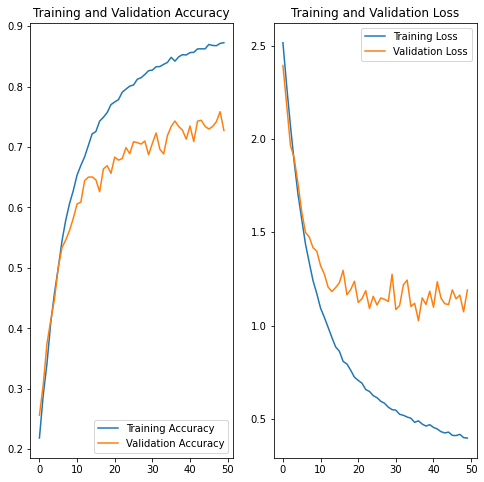

In [43]:
graphmodel(history11)

## Model 12: AVG Pooling?

In [44]:
model12 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(256, activation='relu'),  
  layers.Dense(num_classes, activation='softmax')
])

model12.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [45]:
%%time

epochs=50

history12 = model12.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
847/847 [==============================] - 32s 36ms/step - loss: 2.5024 - accuracy: 0.2239 - val_loss: 2.4078 - val_accuracy: 0.2433
Epoch 2/50
847/847 [==============================] - 31s 36ms/step - loss: 2.3079 - accuracy: 0.2746 - val_loss: 2.2196 - val_accuracy: 0.2989
Epoch 3/50
847/847 [==============================] - 30s 36ms/step - loss: 2.1338 - accuracy: 0.3238 - val_loss: 2.0352 - val_accuracy: 0.3602
Epoch 4/50
847/847 [==============================] - 30s 36ms/step - loss: 1.9527 - accuracy: 0.3778 - val_loss: 1.9368 - val_accuracy: 0.3773
Epoch 5/50
847/847 [==============================] - 30s 35ms/step - loss: 1.7868 - accuracy: 0.4265 - val_loss: 1.7503 - val_accuracy: 0.4469
Epoch 6/50
847/847 [==============================] - 30s 35ms/step - loss: 1.6496 - accuracy: 0.4765 - val_loss: 1.6912 - val_accuracy: 0.4623
Epoch 7/50
847/847 [==============================] - 30s 36ms/step - loss: 1.5112 - accuracy: 0.5185 - val_loss: 1.5509 - val_accuracy:

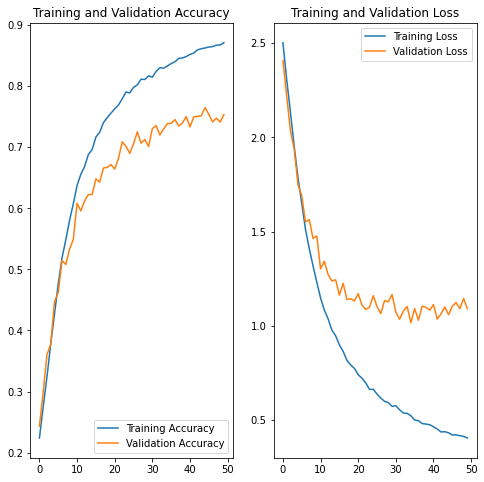

In [46]:
graphmodel(history12)

## Model 13 The Luckiest Model

In [47]:
model13 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 2, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  # layers.Dropout(0.13),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.13),
  layers.Dense(num_classes, activation='softmax')
])

model13.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [48]:
%%time

epochs=100

history13 = model13.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
847/847 [==============================] - 34s 38ms/step - loss: 2.5496 - accuracy: 0.2088 - val_loss: 2.4479 - val_accuracy: 0.2439
Epoch 2/100
847/847 [==============================] - 32s 38ms/step - loss: 2.3656 - accuracy: 0.2710 - val_loss: 2.3099 - val_accuracy: 0.2743
Epoch 3/100
847/847 [==============================] - 32s 38ms/step - loss: 2.2023 - accuracy: 0.3088 - val_loss: 2.1242 - val_accuracy: 0.3394
Epoch 4/100
847/847 [==============================] - 33s 39ms/step - loss: 2.0465 - accuracy: 0.3567 - val_loss: 1.9885 - val_accuracy: 0.3806
Epoch 5/100
847/847 [==============================] - 32s 38ms/step - loss: 1.9088 - accuracy: 0.3937 - val_loss: 1.8467 - val_accuracy: 0.4114
Epoch 6/100
847/847 [==============================] - 31s 37ms/step - loss: 1.7674 - accuracy: 0.4336 - val_loss: 1.7655 - val_accuracy: 0.4202
Epoch 7/100
847/847 [==============================] - 32s 37ms/step - loss: 1.6576 - accuracy: 0.4729 - val_loss: 1.6389 - val_ac

847/847 [==============================] - 32s 37ms/step - loss: 0.6308 - accuracy: 0.7962 - val_loss: 1.1055 - val_accuracy: 0.7082
Epoch 58/100
847/847 [==============================] - 32s 38ms/step - loss: 0.6302 - accuracy: 0.7963 - val_loss: 1.0420 - val_accuracy: 0.7233
Epoch 59/100
847/847 [==============================] - 31s 37ms/step - loss: 0.6157 - accuracy: 0.8009 - val_loss: 1.0853 - val_accuracy: 0.7162
Epoch 60/100
847/847 [==============================] - 31s 37ms/step - loss: 0.6111 - accuracy: 0.8022 - val_loss: 0.9988 - val_accuracy: 0.7295
Epoch 61/100
847/847 [==============================] - 33s 39ms/step - loss: 0.6024 - accuracy: 0.8076 - val_loss: 0.9970 - val_accuracy: 0.7354
Epoch 62/100
847/847 [==============================] - 31s 37ms/step - loss: 0.6086 - accuracy: 0.8057 - val_loss: 1.0258 - val_accuracy: 0.7268
Epoch 63/100
847/847 [==============================] - 31s 37ms/step - loss: 0.5995 - accuracy: 0.8048 - val_loss: 1.0302 - val_accuracy

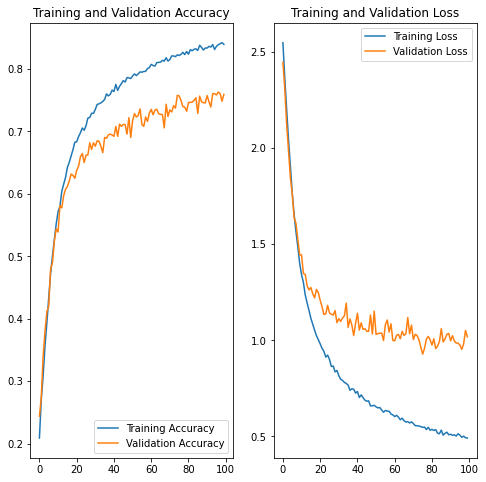

In [49]:
graphmodel(history13)

# Small Batch Tests 

In [50]:
train_ds8 = tf.keras.utils.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="training",
  seed=52,
  image_size=(img_height, img_width),
  batch_size=8)

val_ds8 = tf.keras.utils.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="validation",
  seed=52,
  image_size=(img_height, img_width),
  batch_size=8)

AUTOTUNE = tf.data.AUTOTUNE

train_ds8 = train_ds8.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds8 = val_ds8.cache().prefetch(buffer_size=AUTOTUNE)

Found 33877 files belonging to 17 classes.
Using 27102 files for training.
Found 33877 files belonging to 17 classes.
Using 6775 files for validation.


## Model 14
Based on Model 5, but with smaller dropouts, because a smaller batch size should reduce overfitting.

In [51]:
model14 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes, activation='softmax')
])

model14.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [52]:
%%time

epochs=100

history14 = model14.fit(
  train_ds8,
  validation_data=val_ds8,
  epochs=epochs
)

Epoch 1/100
3388/3388 [==============================] - 28s 7ms/step - loss: 2.4716 - accuracy: 0.2357 - val_loss: 2.2257 - val_accuracy: 0.3058
Epoch 2/100
3388/3388 [==============================] - 21s 6ms/step - loss: 1.9720 - accuracy: 0.3920 - val_loss: 1.6587 - val_accuracy: 0.4912
Epoch 3/100
3388/3388 [==============================] - 20s 6ms/step - loss: 1.4198 - accuracy: 0.5591 - val_loss: 1.2977 - val_accuracy: 0.6143
Epoch 4/100
3388/3388 [==============================] - 20s 6ms/step - loss: 1.0193 - accuracy: 0.6795 - val_loss: 1.0420 - val_accuracy: 0.7086
Epoch 5/100
3388/3388 [==============================] - 20s 6ms/step - loss: 0.7608 - accuracy: 0.7573 - val_loss: 0.9321 - val_accuracy: 0.7517
Epoch 6/100
3388/3388 [==============================] - 20s 6ms/step - loss: 0.6181 - accuracy: 0.8001 - val_loss: 0.8314 - val_accuracy: 0.7885
Epoch 7/100
3388/3388 [==============================] - 20s 6ms/step - loss: 0.5261 - accuracy: 0.8308 - val_loss: 0.8433 -

Epoch 57/100
3388/3388 [==============================] - 19s 6ms/step - loss: 0.1655 - accuracy: 0.9510 - val_loss: 1.0498 - val_accuracy: 0.8663
Epoch 58/100
3388/3388 [==============================] - 19s 6ms/step - loss: 0.1695 - accuracy: 0.9540 - val_loss: 0.8784 - val_accuracy: 0.8655
Epoch 59/100
3388/3388 [==============================] - 19s 6ms/step - loss: 0.1702 - accuracy: 0.9513 - val_loss: 1.0205 - val_accuracy: 0.8652
Epoch 60/100
3388/3388 [==============================] - 19s 6ms/step - loss: 0.1659 - accuracy: 0.9537 - val_loss: 0.9497 - val_accuracy: 0.8623
Epoch 61/100
3388/3388 [==============================] - 19s 6ms/step - loss: 0.1706 - accuracy: 0.9525 - val_loss: 0.9917 - val_accuracy: 0.8676
Epoch 62/100
3388/3388 [==============================] - 19s 6ms/step - loss: 0.1681 - accuracy: 0.9536 - val_loss: 1.0759 - val_accuracy: 0.8633
Epoch 63/100
3388/3388 [==============================] - 20s 6ms/step - loss: 0.1729 - accuracy: 0.9529 - val_loss: 0

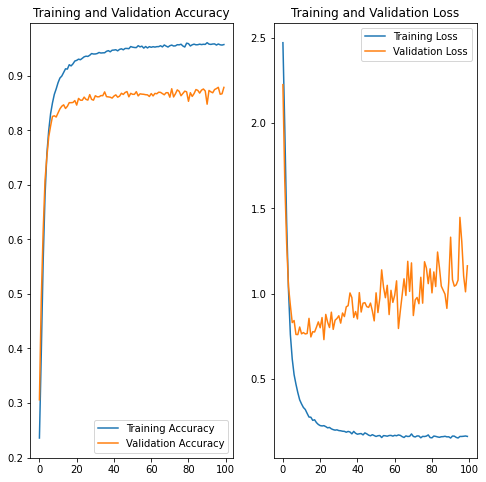

In [53]:
graphmodel(history14)

## Model 15

In [54]:
model15 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(num_classes, activation='softmax')
])

model15.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [55]:
%%time

epochs=100

history15 = model15.fit(
  train_ds8,
  validation_data=val_ds8,
  epochs=epochs
)

Epoch 1/100
3388/3388 [==============================] - 57s 16ms/step - loss: 2.5512 - accuracy: 0.2058 - val_loss: 2.4565 - val_accuracy: 0.2376
Epoch 2/100
3388/3388 [==============================] - 54s 16ms/step - loss: 2.4061 - accuracy: 0.2509 - val_loss: 2.3391 - val_accuracy: 0.2738
Epoch 3/100
3388/3388 [==============================] - 54s 16ms/step - loss: 2.2458 - accuracy: 0.2997 - val_loss: 2.1701 - val_accuracy: 0.3199
Epoch 4/100
3388/3388 [==============================] - 54s 16ms/step - loss: 2.1118 - accuracy: 0.3400 - val_loss: 2.0375 - val_accuracy: 0.3684
Epoch 5/100
3388/3388 [==============================] - 55s 16ms/step - loss: 2.0027 - accuracy: 0.3682 - val_loss: 1.9660 - val_accuracy: 0.3888
Epoch 6/100
3388/3388 [==============================] - 55s 16ms/step - loss: 1.9094 - accuracy: 0.4014 - val_loss: 1.9506 - val_accuracy: 0.4022
Epoch 7/100
3388/3388 [==============================] - 54s 16ms/step - loss: 1.8371 - accuracy: 0.4250 - val_loss: 1

3388/3388 [==============================] - 54s 16ms/step - loss: 1.0191 - accuracy: 0.6823 - val_loss: 1.3879 - val_accuracy: 0.6193
Epoch 57/100
3388/3388 [==============================] - 54s 16ms/step - loss: 1.0294 - accuracy: 0.6787 - val_loss: 1.2543 - val_accuracy: 0.6428
Epoch 58/100
3388/3388 [==============================] - 53s 16ms/step - loss: 1.0049 - accuracy: 0.6877 - val_loss: 1.3470 - val_accuracy: 0.6246
Epoch 59/100
3388/3388 [==============================] - 54s 16ms/step - loss: 1.0040 - accuracy: 0.6903 - val_loss: 1.3876 - val_accuracy: 0.6304
Epoch 60/100
3388/3388 [==============================] - 54s 16ms/step - loss: 0.9939 - accuracy: 0.6926 - val_loss: 1.3058 - val_accuracy: 0.6264
Epoch 61/100
3388/3388 [==============================] - 54s 16ms/step - loss: 1.0097 - accuracy: 0.6871 - val_loss: 1.3664 - val_accuracy: 0.6255
Epoch 62/100
3388/3388 [==============================] - 53s 16ms/step - loss: 1.0015 - accuracy: 0.6887 - val_loss: 1.2576 

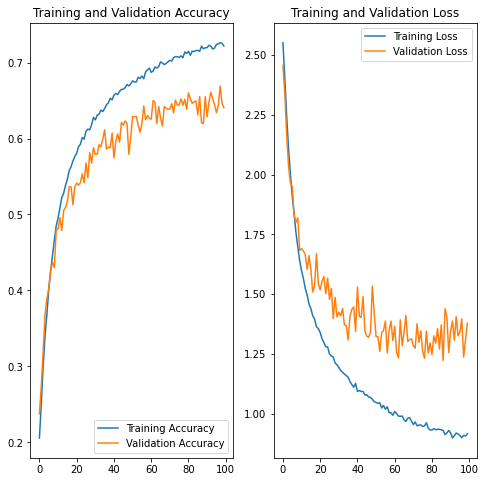

In [56]:
 graphmodel(history15)

## Final Model
Model 6 was the top performer and will be saved for use in the streamlit app

In [57]:
model6.evaluate(test_ds)

212/212 [==============================] - 2s 11ms/step - loss: 0.2379 - accuracy: 0.9466


[0.2378968447446823, 0.9466391801834106]

In [58]:
model6.save('models/type_select_model')

INFO:tensorflow:Assets written to: models/type_select_model\assets


INFO:tensorflow:Assets written to: models/type_select_model\assets
